In [1]:
from utils import Logger,adjust_learning_rate,CreateLogger,create_cosine_learning_schedule,encode_test_label,set_seed
from model import Resnet_with_uncertainty, MLP_with_uncertainty#不确定度
from dependency import *
from torch import optim
from torchcontrib.optim import SWA
from dataloader import generate_dataloader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error # 均方误差
from tensorflow.keras.utils import to_categorical
import pandas as pd
from dependency import *
%matplotlib notebook

In [2]:
from model import Resnet_with_uncertainty,MyCNN,ResNet50_uncertainty,MLP_with_uncertainty
from second_stage_fusion_utils_concat2 import predict,predict3
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error 
import numpy as np
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib notebook

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:05<00:00, 77.21it/s]


In [3]:
import torch.nn.functional as F
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score,accuracy_score, roc_curve,auc,average_precision_score,precision_recall_curve
import cv2
from dependency import *
import pandas as pd
from utils import encode_test_label,Logger,encode_meta_choosed_label,encode_meta_label
from tqdm import tqdm_notebook  

test_index_df = pd.read_csv(test_index_path)
train_index_df = pd.read_csv(train_index_path)
val_index_df = pd.read_csv(val_index_path)

train_index_list = list(train_index_df['indexes'])
val_index_list = list(val_index_df['indexes'])
test_index_list = list(test_index_df['indexes'])

train_index_list_1 = train_index_list[0:206]
train_index_list_2 = train_index_list[206:]

df = pd.read_csv(img_info_path)

In [4]:
def get_label_list(image_index_list):
    diag_label_list = []
    pn_label_list = []
    str_label_list = []
    pig_label_list = []
    rs_label_list = []
    dag_label_list = []
    bwv_label_list = []
    vs_label_list = []
    meta_list = []
    meta_list_one_hot = []
    
    img_feature = []
    img_hf_feature = []
    img_vf_feature = []
    img_vhf_feature = []

    from sklearn.decomposition import PCA

    from tqdm import tqdm_notebook,tqdm
    for index_num in tqdm(image_index_list):
    #index_num = test_index_list[100]
        img_info = df[index_num:index_num+1]
        clinic_path = img_info['clinic']
        dermoscopy_path = img_info['derm']
        source_dir = '../release_v0/release_v0/images/'
        clinic_img = cv2.imread(source_dir+clinic_path[index_num])
        dermoscopy_img = cv2.imread(source_dir+dermoscopy_path[index_num])
        '''这里对于metadata需要变更'''
        meta_vector_one_hot,meta_vector = encode_meta_choosed_label(img_info,index_num)
        
        [diagnosis_label,pigment_network_label,streaks_label,pigmentation_label,regression_structures_label,
         dots_and_globules_label,blue_whitish_veil_label, vascular_structures_label],[diagnosis_label_one_hot,pigment_network_label_one_hot,
        streaks_label_one_hot,pigmentation_label_one_hot,regression_structures_label_one_hot,
        dots_and_globules_label_one_hot,blue_whitish_veil_label_one_hot, vascular_structures_label_one_hot] = encode_test_label(img_info,index_num)

        diag_label_list.append(diagnosis_label)
        pn_label_list.append(pigment_network_label)
        str_label_list.append(streaks_label)
        pig_label_list.append(pigmentation_label)
        rs_label_list.append(regression_structures_label)
        dag_label_list.append(dots_and_globules_label)
        bwv_label_list.append(blue_whitish_veil_label)
        vs_label_list.append(vascular_structures_label)
        meta_list.append(meta_vector)
        meta_list_one_hot.append(meta_vector_one_hot)



    label_dict ={'diag':diag_label_list,
                 'pn':pn_label_list,
                 'str':str_label_list,
                 'pig':pig_label_list,
                 'rs':rs_label_list,
                 'dag':dag_label_list,
                 'bwv':bwv_label_list,
                 'vs':vs_label_list}
    
    return label_dict,meta_list,meta_list_one_hot

# multi-modality with uncertainty(derm, clinic, and metadata) fusion here

./multimodal(copy2)_Resnet_cos-loss and concat_Normal_weight_file/4/checkpoint/best_mean_acc_model.pth
./multimodal_MLP_Normal_weight_file/4/checkpoint/best_mean_acc_model.pth
P1--------------------------------on images

--- [START IDENTIFIER] ----------------------------------------------------------------




100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:40<00:00,  9.81it/s]
E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:1253: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_diag_sk = Tp_diag_sk / (Tp_diag_sk + Fp_diag_sk)


---------------

avg_acc : 0.7481012658227848

vs_acc : 0.8177215189873418

bwv_acc : 0.8759493670886076

dag_acc : 0.6455696202531646

rs_acc : 0.7949367088607595

pig_acc : 0.7164556962025317

str_acc : 0.7468354430379747

pn_acc : 0.6759493670886076

diag_acc : 0.7113924050632912

Diag-------------------------

nevu_SEN: 0.9041095890410958, SPE: 0.6704545454545454, PRE: 0.7734375
bcc SEN: 0.3125, SPE: 0.978891820580475, PRE: 0.38461538461538464
mel SEN: 0.6732673267326733, SPE: 0.8673469387755102, PRE: 0.6355140186915887
misc SEN: 0.25, SPE: 0.9746478873239437, PRE: 0.5263157894736842
sk SEN: 0.0, SPE: 1.0, PRE: nan
----------

pn_asb SEN: 0.7307692307692307, SPE: 0.8493723849372385, PRE: 0.76
pn_typ SEN: 0.7465753424657534, SPE: 0.7831325301204819, PRE: 0.6687116564417178
pn_aty SEN: 0.4731182795698925, SPE: 0.8741721854304636, PRE: 0.5365853658536586
----------

str_asb SEN: 0.8988326848249028, SPE: 0.572463768115942, PRE: 0.7965517241379311
str_reg SEN: 0.5, SPE: 0.97150997150997

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:41<00:00,  9.56it/s]
E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:1240: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_vs_irg = Tp_vs_irg / (Tp_vs_irg + Fp_vs_irg)
E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:1253: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_diag_sk = Tp_diag_sk / (Tp_diag_sk + Fp_diag_sk)


---------------

avg_acc : 0.7604430379746836

vs_acc : 0.7974683544303798

bwv_acc : 0.8835443037974684

dag_acc : 0.6860759493670886

rs_acc : 0.8025316455696202

pig_acc : 0.6936708860759494

str_acc : 0.739240506329114

pn_acc : 0.7291139240506329

diag_acc : 0.7518987341772152

Diag-------------------------

nevu_SEN: 0.9497716894977168, SPE: 0.6193181818181818, PRE: 0.7563636363636363
bcc SEN: 0.625, SPE: 0.9841688654353562, PRE: 0.625
mel SEN: 0.6732673267326733, SPE: 0.935374149659864, PRE: 0.7816091954022989
misc SEN: 0.275, SPE: 0.9830985915492958, PRE: 0.6470588235294118
sk SEN: 0.0, SPE: 1.0, PRE: nan
----------

pn_asb SEN: 0.8141025641025641, SPE: 0.8535564853556485, PRE: 0.7839506172839507
pn_typ SEN: 0.7808219178082192, SPE: 0.8353413654618473, PRE: 0.7354838709677419
pn_aty SEN: 0.5053763440860215, SPE: 0.8973509933774835, PRE: 0.6025641025641025
----------

str_asb SEN: 0.9416342412451362, SPE: 0.42028985507246375, PRE: 0.7515527950310559
str_reg SEN: 0.20454545454545

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:42<00:00,  9.29it/s]


<IPython.core.display.Javascript object>


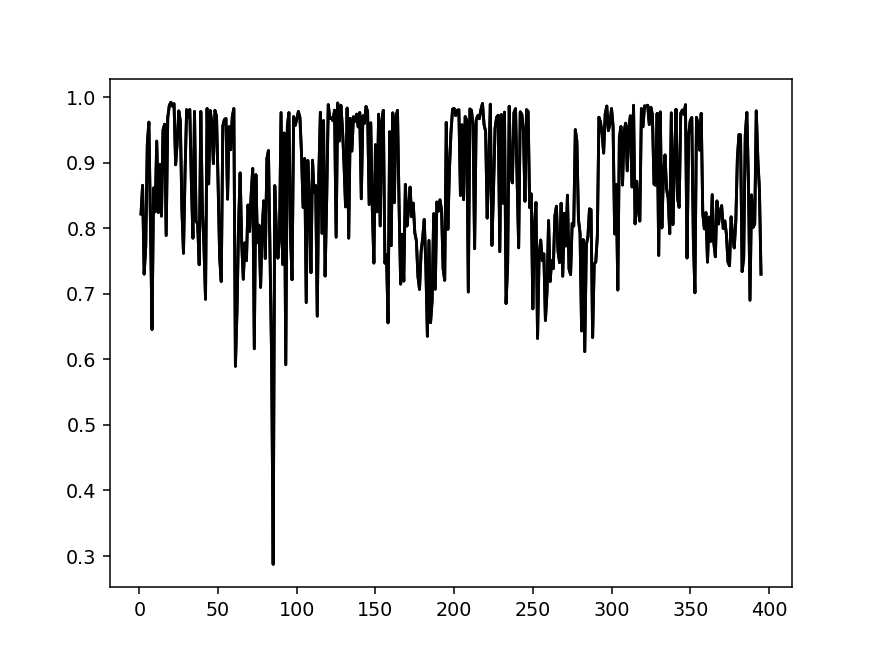

E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:2471: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_vs_irg = Tp_vs_irg / (Tp_vs_irg + Fp_vs_irg)
E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:2487: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_diag_sk = Tp_diag_sk / (Tp_diag_sk + Fp_diag_sk)


---------------

avg_acc : 0.7607594936708861

vs_acc : 0.7949367088607595

bwv_acc : 0.8860759493670886

dag_acc : 0.6886075949367089

rs_acc : 0.8025316455696202

pig_acc : 0.6962025316455697

str_acc : 0.7367088607594937

pn_acc : 0.7265822784810126

diag_acc : 0.7544303797468355

Diag-------------------------

nevu_SEN: 0.9497716894977168, SPE: 0.625, PRE: 0.7591240875912408
bcc SEN: 0.625, SPE: 0.9815303430079155, PRE: 0.5882352941176471
mel SEN: 0.6732673267326733, SPE: 0.935374149659864, PRE: 0.7816091954022989
misc SEN: 0.3, SPE: 0.9859154929577465, PRE: 0.7058823529411765
sk SEN: 0.0, SPE: 1.0, PRE: nan
----------

pn_asb SEN: 0.8076923076923077, SPE: 0.8535564853556485, PRE: 0.782608695652174
pn_typ SEN: 0.7945205479452054, SPE: 0.8313253012048193, PRE: 0.7341772151898734
pn_aty SEN: 0.4838709677419355, SPE: 0.8973509933774835, PRE: 0.5921052631578947
----------

str_asb SEN: 0.9416342412451362, SPE: 0.4057971014492754, PRE: 0.7469135802469136
str_reg SEN: 0.20454545454545456

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.07it/s]
E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:2471: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_vs_irg = Tp_vs_irg / (Tp_vs_irg + Fp_vs_irg)
E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:2487: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_diag_sk = Tp_diag_sk / (Tp_diag_sk + Fp_diag_sk)


---------------

avg_acc : 0.760601265822785

vs_acc : 0.7949367088607595

bwv_acc : 0.8873417721518987

dag_acc : 0.6848101265822785

rs_acc : 0.8012658227848102

pig_acc : 0.7012658227848101

str_acc : 0.7379746835443038

pn_acc : 0.7227848101265822

diag_acc : 0.7544303797468355

Diag-------------------------

nevu_SEN: 0.9452054794520548, SPE: 0.6278409090909091, PRE: 0.7596330275229358
bcc SEN: 0.625, SPE: 0.9828496042216359, PRE: 0.6060606060606061
mel SEN: 0.6831683168316832, SPE: 0.9319727891156463, PRE: 0.7752808988764045
misc SEN: 0.3, SPE: 0.9859154929577465, PRE: 0.7058823529411765
sk SEN: 0.0, SPE: 1.0, PRE: nan
----------

pn_asb SEN: 0.8044871794871795, SPE: 0.8493723849372385, PRE: 0.7770897832817337
pn_typ SEN: 0.791095890410959, SPE: 0.8253012048192772, PRE: 0.7264150943396226
pn_aty SEN: 0.478494623655914, SPE: 0.9006622516556292, PRE: 0.5973154362416108
----------

str_asb SEN: 0.9416342412451362, SPE: 0.41304347826086957, PRE: 0.7492260061919505
str_reg SEN: 0.2045

In [10]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
seed = 0
mode = 'multimodal(copy2)'
model_name = 'Resnet_cos-loss and concat'
import random
random.seed(seed)
TTA = 6
img_type="concat"
size = 224
data_mode = 'Normal'

#change i here!
i = 4

p1_acc_list = []
p2_acc_list = []
p3_acc_list = []

mean_avg_acc_list = []

weight_file = './{}_{}_{}_weight_file/{}/checkpoint/best_mean_acc_model.pth'.format(mode,model_name,data_mode,i)
print(weight_file)

net = Resnet_with_uncertainty(class_list).cuda()
net.load_state_dict(torch.load(weight_file))

weight_file2 = './{}_{}_{}_weight_file/{}/checkpoint/best_mean_acc_model.pth'.format("multimodal","MLP",data_mode,i)
print(weight_file2)

net2 =  MLP_with_uncertainty(class_list).cuda()

net2.load_state_dict(torch.load(weight_file2))
print("P1--------------------------------on images")
out_dir = './{}_{}_result/{}/'.format(mode,model_name,"P1")
(avg_acc,uncertainty_pred,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict(net2,net,test_index_list,df,
                                                                    model_name,out_dir,mode,TTA,size,img_type,"img")
print("P2--------------------------------on metadata")
out_dir = './{}_{}_result/{}/'.format(mode,model_name,"P2")
(avg_acc,uncertainty_pred,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict(net2,net,test_index_list,df,
                                                                    model_name,out_dir,mode,TTA,size,img_type,"metadata")
prob_2 = prob
pn_prob_2 = pn_prob
str_prob_2 = str_prob
pig_prob_2 = pig_prob
rs_prob_2 = rs_prob
dag_prob_2 = dag_prob
bwv_prob_2 = bwv_prob
vs_prob_2 = vs_prob
uncertainty_2 = uncertainty_pred
p2_list  = [prob_2,pn_prob_2,str_prob_2,pig_prob_2,rs_prob_2,dag_prob_2,bwv_prob_2,vs_prob_2,uncertainty_2]
print("P2 Done")

print("(clinic, derm)-concat & metadata fusion here!------------------------------------------------")
out_dir = './{}_{}_result/{}/'.format(mode,model_name,"P3")
(avg_acc,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict3(net,net2,test_index_list,df,model_name,out_dir,mode,TTA,size,img_type)
